# Content

5. [Topic Analysis](#5.-Topic-Analysis)  
    5.1. [Politicians party](#5.1.-Politicians-party)   
    5.2. [Which politicians talked the most?](#5.2.-Which-politicians-talked-the-most?)   
    5.3. [Topic analysis](#5.3.-Topic-analysis)   
    ㅤㅤ5.3.1. [Dominant topics by politicians](#5.3.1.-Dominant-topics-by-politicians)   
    ㅤㅤ5.3.2. [Dominant topics by quotes](#5.3.2.-Dominant-topics-by-quotes)   
    ㅤㅤ5.3.3. [Topic sentiments](#5.3.3.-Topic-sentiments)   
    ㅤㅤ5.3.4. [Divisive topics](#5.3.4.-Divisive-topics)   
    ㅤㅤ5.3.5. [Sentiment of selected speakers](#5.3.5.-Sentiment-of-selected-speakers)


# **5. Topic Analysis**

Having created the opinions and counts matrices, we now want to analyze them to get insights about what are the most discussed, strongly feeled and divisive topics, by partisan membership.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bertopic

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from bertopic import BERTopic
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

from IPython.display import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
topics_folder = '/content/drive/MyDrive/ADA/Topics/'
opinion_folder = '/content/drive/MyDrive/ADA/Opinions/'
politicians_folder = '/content/drive/MyDrive/ADA/Politicians/'
image_folder = '/content/drive/MyDrive/ADA/Images/'

In [ ]:
import datetime
import pytz
def printts(*objects):
    print(datetime.datetime.now(pytz.timezone('Europe/Zurich')).strftime("%d %b %Y %H:%M:%S"), ":", *objects)

In [ ]:
RED = '#be0b06'
BLUE = '#0628f8'

## 5.1. Politicians party

Before diving into the analysis, we need to enrich the politicians -> quotes matrix adding information about the political party each politician belongs to, scraped from WikiData. Due to the fact that we only consider a short timespan of 5 years, it is unlikely that during this interval a lot of people have changed their party, and it is also unlikely they have done so from 2020 to now (December 2021). Hence, we assume for simplicity that for all the quotes we can assign to each speaker the party in which he currently belongs, i.e. the last party he has been member of. In addition, we will also enrich our data with the number of quotes per politicians, based on which we will later filter our opinions matrix.

In [ ]:
df_politicians = pd.read_parquet(os.path.join(politicians_folder, 'politicians_raw.parquet'))

In [ ]:
import requests

def get_political_party(qid):
  '''
  This function outputs the political party of a speaker defined by their QID.
  Example: get_political_party('Q22686') returns 'Q29468'. (Donald trump, Republican Party.)
  If no political party was found on Wikidata, it outputs 'unknown'.
  '''
  QID_POLTICAL_PARTY = 'P102'
  url = 'https://www.wikidata.org/w/api.php'

  params = {
      'action': 'wbgetclaims',
      'format': 'json',
      'entity': qid
  }

  data = requests.get(url, params=params).json()
  try:
    political_parties = data['claims'][QID_POLTICAL_PARTY]
    last_political_party = political_parties[len(political_parties)-1]
    party = last_political_party['mainsnak']['datavalue']['value']['id']
  except:
    party = 'unknown'

  return party

In [ ]:
df_politicians['num_quotations'] = df_politicians.indexes.apply(lambda x: len(x))
df_politicians['party_id'] = pd.Series(df_politicians.index).apply(get_political_party).values

Next, we need to map party QIDs to their name, for which we can again query Wikidata.

In [ ]:
def get_label_from_qid(qid):
  '''
  This function gets the textual label of a QID.
  Example: get_label_from_qid('Q29468') returns 'Republican Party'.
  '''
  url = 'https://www.wikidata.org/w/api.php'
  params = {
      'action': 'wbsearchentities',
      'format': 'json',
      'language': 'en',
      'search': qid
  }
  try:
    data = requests.get(url, params=params).json()
    label = data['search'][0]['label']
  except:
    label = 'unknown'
  return label

In [ ]:
# Get party distribution in our dataset
num_politicians_per_party = df_politicians.party_id.value_counts()
party_ids = pd.DataFrame(index=num_politicians_per_party.index)
party_ids['party_name'] = pd.Series(party_ids.index).apply(get_label_from_qid).values
party_ids['num_politicians'] = num_politicians_per_party.values
party_ids 

In [ ]:
# Add column with name of the party
df_politicians['party'] = df_politicians.party_id.apply(lambda x: party_ids.party_name.to_dict()[x])

In [ ]:
# Who are the unknowns?
df_politicians[df_politicians.party=='anonymous']

,indexes,speaker,num_quotations,party_id,party
qids,,,,,
Q1063311,"[q676943, q1033855, q1035973, q1295346, q20158...",Charlene Mitchell,14,unknown,anonymous
Q11107,"[q1746, q2067, q4133, q4292, q9808, q9913, q15...",Sonia Sotomayor,4703,unknown,anonymous
Q11288727,"[q92973, q224996, q350560, q437415, q1143760, ...",Wallace Gregson,29,unknown,anonymous
Q1134596,"[q32890, q237700, q242094, q296847, q381628, q...",Joe Saunders,73,unknown,anonymous
Q1162872,"[q1882, q7536, q10218, q11238, q18327, q21151,...",Daniel Brown,1599,unknown,anonymous
...,...,...,...,...,...
Q968168,"[q8221, q12743, q12785, q191615, q241618, q245...",Jeff Monson,126,unknown,anonymous
Q969273,"[q13333, q25776, q27025, q47802, q54543, q6978...",José Graziano da Silva,1144,unknown,anonymous
Q978484,[q1400804],Ronald D. Asmus,1,unknown,anonymous


People with unknown values do not have an entry in WikiData for property P102, i.e. political party. These are often people that are involved in some governmental institutions, but that are not exactly politicians nor elected. Examples of such cases are Sonia Sotomayor, judge in the Supreme Court, or José Graziano da Silva, General Director of the Food and Agriculture Organization (FAO).

In [ ]:
# Save file
df_politicians.to_parquet(os.path.join(politicians_folder, 'politicians.parquet'))

## 5.2 Which politicians talked the most?


Now that we know to which party each politician belongs, let's get an idea about the top 10 politicians that are most represented in our reduced dataset, and to which party they belong.

In [ ]:
# Load politicians
df_politicians = pd.read_parquet(os.path.join(politicians_folder, 'politicians.parquet'))

In [ ]:
df_politicians_sorted = df_politicians.sort_values(by='num_quotations',ascending=False)

fig = px.bar(df_politicians_sorted[:10], 
             x='speaker', y='num_quotations', color='party',
             log_y=True, 
             color_discrete_sequence=[RED,BLUE,'grey'],
             labels={
                     'num_quotations': 'number of quotations',
                     'speaker': 'politician'
             },
             width=800, height=500
)

fig.update_layout(xaxis={'categoryorder':'total descending'},
                  yaxis_range=[4.5, 6],
                  legend=dict(
                          yanchor="top",
                          y=0.97,
                          xanchor="right",
                          x=0.99,
                          )
)

fig.show()
fig.write_html(os.path.join(image_folder,'number_of_quotes.html'))

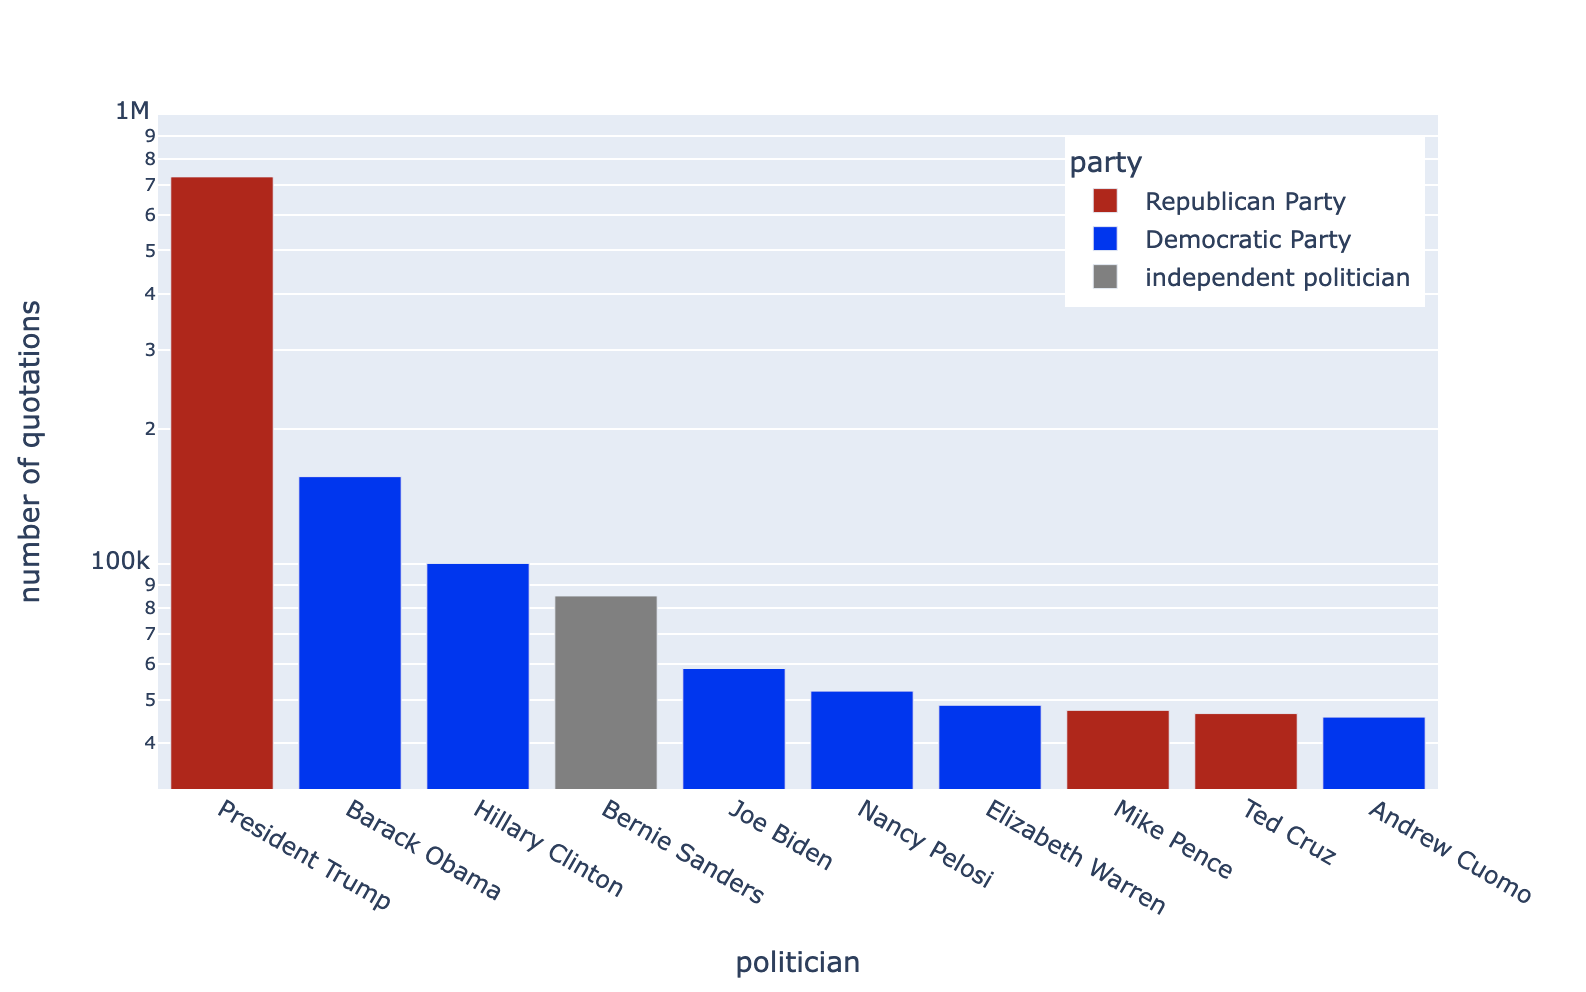

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/Topic_analysis/distribution_of_quotes.png')

## 5.3. Topic Analysis

Next, we aim to interpret the topics learned by BERTopic.

In [ ]:
# Load BERTopic model
MODEL_NAME = 'topics_6.0e+05_10df_1000'
topic_model = BERTopic.load(os.path.join(topics_folder, MODEL_NAME), embedding_model="all-MiniLM-L6-v2")

In [ ]:
# Load matrices
opinions = pd.read_parquet(os.path.join(opinion_folder, 'opinions.parquet'))
counts = pd.read_parquet(os.path.join(opinion_folder, 'counts.parquet'))
df_politicians = pd.read_parquet(os.path.join(politicians_folder, 'politicians.parquet'))

In [ ]:
# Remove topic -1, which corresponds to outliers and unmeaningful words.
opinions = opinions.drop(columns=['-1'])
counts = counts.drop(columns=['-1'])

For all the subsequent analysis, we focus only on politicians which have at least 1000 quotes and that have expressed their views on at least 15% of the extracted topics.

In [ ]:
num_politicians, num_topics = opinions.shape

In [ ]:
min_percentage_topics = 0.15
min_quotes = 1000

In [ ]:
politicians_filtered = df_politicians[(opinions.notnull().sum(axis=1) / num_topics >= min_percentage_topics).values
                                      & (df_politicians.num_quotations >= min_quotes).values]
opinions_filtered = opinions[(opinions.notnull().sum(axis=1) / num_topics >= min_percentage_topics).values
                             & (df_politicians.num_quotations >= min_quotes).values]
counts_filtered = counts[(counts.notnull().sum(axis=1) / num_topics >= min_percentage_topics).values
                            & (df_politicians.num_quotations >= min_quotes).values]

print('Number of politicians after filtering: ', len(opinions_filtered))

Number of politicians after filtering:  1641


In [ ]:
selected_speakers = np.array(['Joe Biden', 'President Trump', 'Alexandria Ocasio-Cortez', 
                              'Bernie Sanders', 'Mike Pence', 'Mike Pompeo', 'Hillary Clinton', 
                              'Kamala Harris', 'Ted Cruz', 'Nancy Pelosi', 'Mitch McConnell', 
                              'Lindsey Graham', 'Elizabeth Warren', 'Ilhan Omar',
                              'Barack Obama', 'John McCain', 'President Clinton',
                              'Joe Manchin', 'Mitt Romney'])

### 5.3.1 Dominant topics by politicians

Which topics are most talked about, in terms of number of politicians?

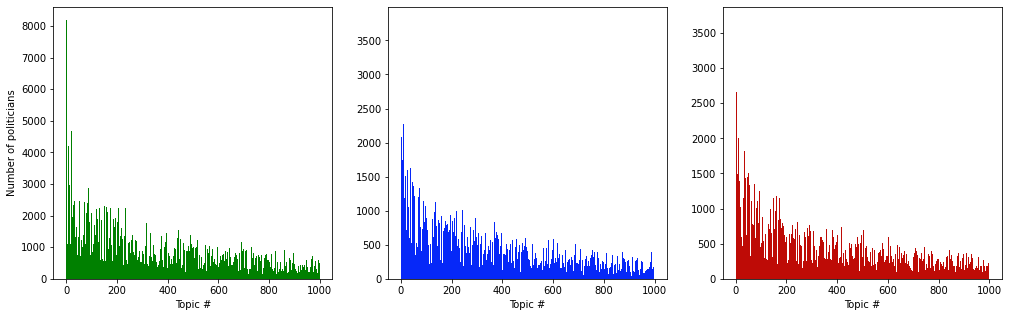

In [ ]:
# For each topic, plot how many politicians talked about it
fig, ax = plt.subplots(1,3, figsize=(17,5))

ax[0].bar(np.arange(0,1000), opinions.notnull().sum(), color='green', width=1)
ax[0].set_ylabel('Number of politicians')
ax[0].set_xlabel('Topic #')
ax[1].bar(np.arange(0,1000), opinions[df_politicians.party=='Democratic Party'].notnull().sum(), color=BLUE, width=1)
ax[1].set_xlabel('Topic #')
ax[2].bar(np.arange(0,1000), opinions[df_politicians.party=='Republican Party'].notnull().sum(), color=RED, width=1)
ax[2].set_xlabel('Topic #');

### 5.3.2. Dominant topics by quotes

Which the topics that are most talked about, in terms of number of quotes?
Note that with 'number of quotes' we refer to the number of quotes in the *training dataset* only.

In [ ]:
# Get the 8 topics that are most represented in the training data 
topic_model.visualize_barchart()

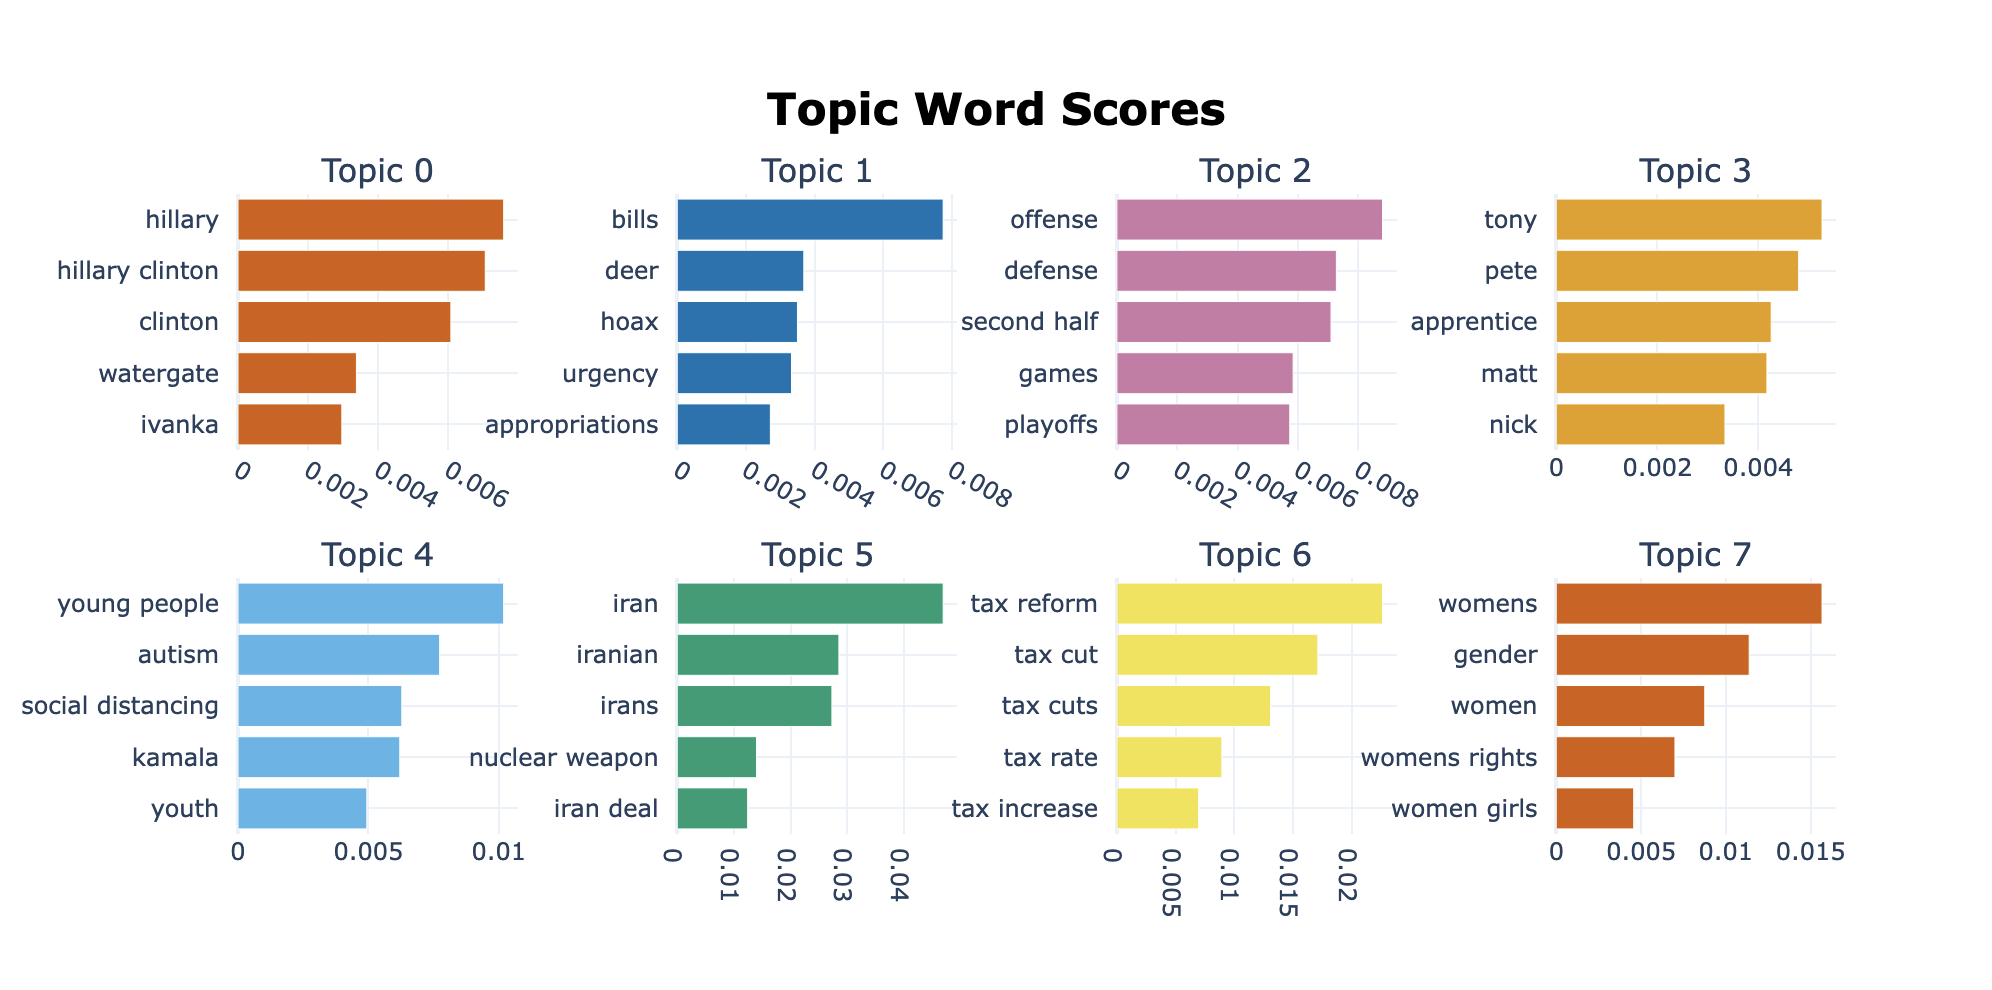

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/Topic_analysis/topic_barplot.png')

To interpret the topics, only 4 words might not be enough. Let's look more closely into the quotes that represent the topics :

In [ ]:
# Get representative quotes for the top 10 quotes most talked about
for ii in range(10):
  docs = topic_model.get_representative_docs(ii)[:20]
  print(f'Topic {ii}:')
  [print(d) for d in docs]
  print('\n')

Topic 0:
We are extremely grateful to both the US National Science Foundation and the USGS Hawaiian Volcano Observatory for funding and supporting this research into the current eruption at Kīlauea, using a range of rapid-response tools,
Volcanoes all over the Earth will erupt along with multiple high magnitude earthquakes, tidal waves, and a meteor firestorm.
volcano remains a rich resource for the imagination.
She's been stable since probably yesterday evening, and they're hoping that the antibiotics will start to work,
We have our days, but really, we're hoping that her treatments work and that she'll be free of it one day.
Chloe Barnes Advisory Council on Rare Disorders.
At the senior staff meeting, Ivanka couldn't stop bemoaning it, how offensive it was, how ridiculous it was,
No, Ivana is not going to have a fish. She is going to have a steak.
Ivanka is a woman of great grace and kindness and has been a good friend to me,
That is tradition, and that is honoring tradition of those

That's a lot of text, but based on this we see that quotes 0-4 are difficult to interpret. They consist of a lot of quotations, which are often about several different topics.

However, quotes 5-9 are much better interpretable. We can represent their content as wordclouds:

In [ ]:
def topic_wordcloud(representative_docs):
  '''
  build wordcloud for the topic given as argument.
  '''
  stp = stopwords.words('english') 
  words = ''.join(representative_docs)
  return WordCloud(width=800, height=560,
                        background_color='white', collocations=False,
                        min_font_size=10, stopwords = stp).generate(words)

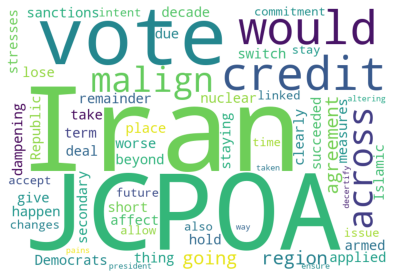

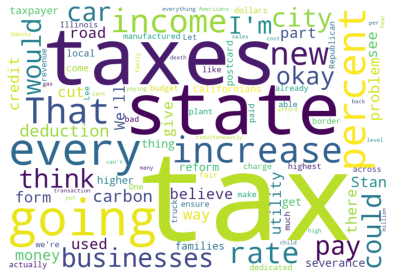

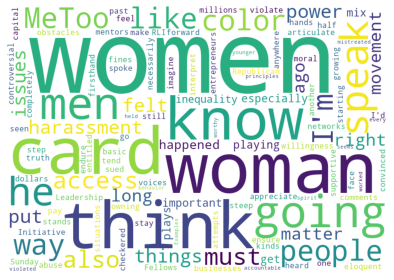

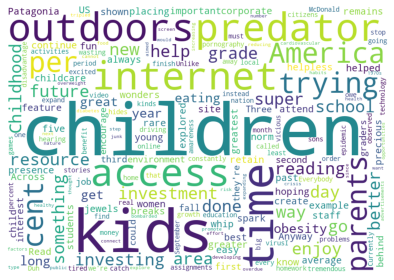

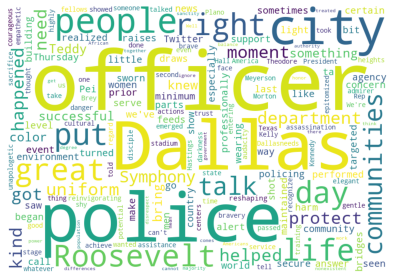

In [ ]:
# Wordcloud for a list of topics
topic_nrs = [5, 6, 7, 8, 9]

for nr in topic_nrs:
  plt.figure(figsize=(6, 4), facecolor=None)
  wordcloud = topic_wordcloud(topic_model.get_representative_docs(nr))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.savefig(os.path.join(image_folder,'wordcloud_topic_' + str(nr) + '.png'))
  plt.show()
  print("")

Now that we have a better idea of what these popular topics are about, let's summarize them in a few words:

In [ ]:
popular_topic_descriptions = {'5': 'Iran nuclear deal',
                              '6': 'Tax policy',
                              '7': 'Gender and race equality',
                              '8': 'Youth',
                              '9': 'Police'}

### 5.3.3. Topic sentiments

Next, we combine the topic extraction with sentiment analysis: about which topics do politicians have strong opinions? And is this distribution different for democrats and republicans?

In [ ]:
opinions_sorted = opinions_filtered.mean().sort_values()
opinions_filtered[opinions_sorted.index]

,932,578,644,978,647,598,796,596,61,275,787,174,692,649,519,839,400,454,398,577,686,464,453,531,979,520,452,681,270,460,366,207,722,983,554,424,730,675,466,511,...,964,856,320,780,625,433,971,138,491,498,203,868,735,777,708,910,567,110,779,829,691,558,847,646,402,170,668,489,731,894,789,231,158,272,390,994,810,631,799,233
qids,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q1027026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.720625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.636900,NaN,NaN,NaN,0.810400,NaN,NaN,-0.718400,NaN,NaN,NaN,NaN,NaN,-0.812500,NaN,NaN,NaN,0.88600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.502250,-0.03305,0.726400,0.718400,NaN,0.721650,NaN,0.57805,NaN,NaN,0.692183,NaN,NaN,NaN,0.816300,NaN,NaN,0.571900,-0.273200,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.542300
Q1029527,-0.8020,NaN,NaN,NaN,-0.70730,NaN,NaN,NaN,-0.777100,-0.561500,NaN,NaN,NaN,NaN,NaN,NaN,-0.543150,-0.367300,-0.606200,NaN,NaN,NaN,-0.458800,NaN,NaN,NaN,NaN,NaN,-0.61240,NaN,NaN,-0.721200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.380217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930900,NaN,0.9445,NaN,NaN,0.899667,NaN,0.790600,NaN,0.807000,NaN,NaN,0.871800,NaN,NaN,0.624900,NaN,NaN,NaN,NaN,NaN,NaN,0.554200
Q10390,-0.8354,0.0000,-0.398867,NaN,-0.45425,-0.6478,-0.41045,-0.379813,-0.478148,-0.672508,-0.763980,-0.456580,NaN,-0.63580,-0.8382,-0.340325,-0.483394,-0.526967,-0.352009,-0.54288,-0.3437,-0.4215,-0.180556,-0.613471,-0.464227,-0.538462,-0.058275,NaN,-0.57522,NaN,-0.513825,-0.376765,-0.272589,-0.496383,-0.23916,-0.42878,NaN,-0.3859,-0.060300,-0.295180,...,0.332526,0.5244,0.410112,NaN,0.2938,NaN,-0.12440,0.300944,0.45990,0.486329,0.378496,NaN,0.559025,NaN,0.61240,NaN,0.062650,0.380100,0.137718,NaN,0.580567,0.280167,0.370933,0.35735,0.566093,0.531814,0.727908,0.38765,0.715407,0.502317,0.410612,0.284865,0.361200,0.681650,0.608800,0.191271,NaN,NaN,0.9346,0.852337
Q1047146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.588933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.743000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.295800,-0.778300,NaN,-0.458800,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.9524,NaN,0.486100,0.57190,NaN,NaN,NaN,NaN,NaN,0.55115,NaN,NaN,0.526700,NaN,NaN,0.400500,NaN,NaN,NaN,NaN,0.493900,0.895700,NaN,NaN,NaN,NaN,NaN,0.571900,NaN,NaN,0.732800,NaN,NaN,NaN,0.940300
Q1058745,NaN,NaN,-0.765000,NaN,-0.84810,NaN,NaN,NaN,-0.847800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.61150,NaN,NaN,-0.114300,NaN,NaN,NaN,-0.797950,NaN,NaN,NaN,NaN,NaN,NaN,-0.768400,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038600,NaN,0.476700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.70630,-0.077200,NaN,NaN,NaN,NaN,NaN,0.485400,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q983055,NaN,NaN,NaN,NaN,NaN,NaN,-0.37645,NaN,-0.630473,NaN,-0.208250,-0.642467,NaN,-0.32985,NaN,NaN,NaN,-0.761133,-0.636900,-0.27320,NaN,NaN,-0.709600,-0.361200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.208247,...,NaN,NaN,0.812600,NaN,NaN,NaN,NaN,0.464300,0.57190,NaN,0.626250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.709600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.530450,NaN,NaN,NaN,NaN,0.732980,NaN,NaN,NaN,NaN,NaN,0.759700
Q983537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.829750,-0.660200,NaN,-0.640300,NaN,NaN,-0.2732,NaN,NaN,NaN,-0.845250,NaN,NaN,NaN,NaN,NaN,-0.440400,NaN,-0.750600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.49390,NaN,NaN,NaN,0.703000,NaN,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.96480,NaN,NaN,NaN,0.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.790657,0.750600,NaN,0.81260,NaN,NaN,NaN,NaN,0.713750,NaN,NaN,0.471733,NaN,NaN,NaN,NaN
Q983981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.648600,NaN,NaN,NaN,-0.59940

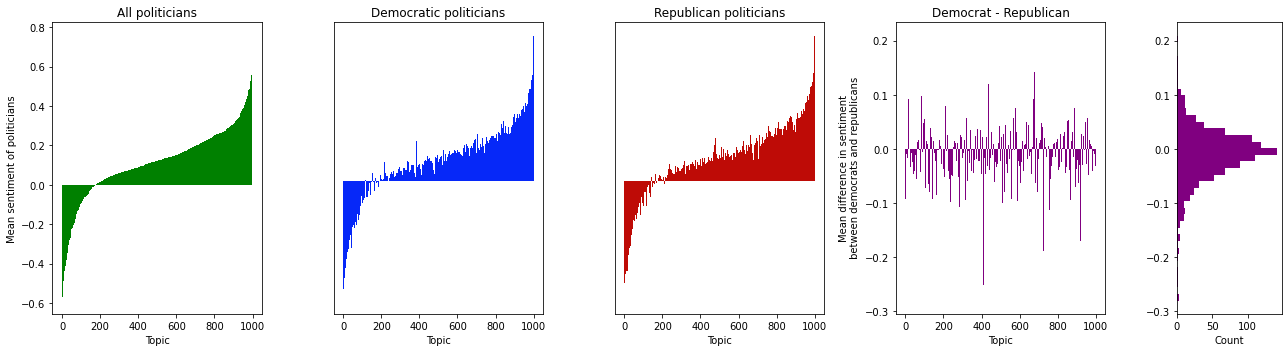

In [ ]:
# Distribution: what are the mean opinions?
fig, ax = plt.subplots(1,5, figsize=(18,5), gridspec_kw={'width_ratios': [1,1,1,1,0.5]})

# Sort dataframe based on the mean opinion, considering all politicians
sorted_opinions = opinions_filtered[opinions_filtered.mean().sort_values().index]

# Find opinions of democrats and republicans per topic, and their difference
sorted_democrat_opinions = sorted_opinions[politicians_filtered.party=='Democratic Party']
sorted_republican_opinions = sorted_opinions[politicians_filtered.party=='Republican Party']
opinion_difference = sorted_democrat_opinions.mean() - sorted_republican_opinions.mean()

# All politicians
ax[0].bar(np.arange(0,1000), sorted_opinions.mean(), color='green', width=1)
ax[0].set_title('All politicians')
ax[0].set_xlabel('Topic')
ax[0].set_ylabel('Mean sentiment of politicians')

# Democrats
ax[1].bar(np.arange(0,1000), sorted_democrat_opinions.mean(), color=BLUE, width=1)
ax[1].set_title('Democratic politicians')
ax[1].set_xlabel('Topic')
ax[1].set_yticks([])

# Republicans
ax[2].bar(np.arange(0,1000), sorted_republican_opinions.mean(), color=RED, width=1)
ax[2].set_title('Republican politicians')
ax[2].set_xlabel('Topic')
ax[2].set_yticks([])

# Democrats - republicans
ax[3].bar(np.arange(0,1000), opinion_difference, color='purple', width=1)
ax[3].set_title('Democrat - Republican')
ax[3].set_xlabel('Topic')
ax[3].set_ylabel('Mean difference in sentiment\n between democrats and republicans')

ax[4].hist(opinion_difference, color='purple', bins=40, orientation='horizontal')
ax[4].set_xlabel('Count')

plt.tight_layout()

We are mostly interested in the topics that *divide* republicans and democrats, which is why we plot the difference of their sentiment for each topic (on the right in purple). Surprisingly, we see that democrats and republicans have similar opinions on most topics. Next, we investigate the topics at the 'tail' of the purple distribution, i.e. those topics that divide republicans and democrats the most.

### 5.3.4. Divisive topics

We identify the 10 topics with the largest difference in mean sentiment between republicans and democrats.

In [ ]:
num_divisive_topics = 10
divisive_topics = opinion_difference.abs().sort_values(ascending=False)[:num_divisive_topics].to_frame(name='sentiment_difference')
divisive_topics

,sentiment_difference
920,0.280311
558,0.273522
380,0.271199
680,0.251109
143,0.234261
208,0.223304
360,0.209289
841,0.204789
566,0.198632
407,0.190828


In [ ]:
# Get representative docs of the (at most) 10 most divisive topics
for topic in divisive_topics.index:
  republican_sentiment = opinions_filtered.loc[politicians_filtered.party=='Republican Party', topic].mean()
  democrat_sentiment = opinions_filtered.loc[politicians_filtered.party=='Democratic Party', topic].mean()
  docs = topic_model.get_representative_docs(int(topic))[:20]
  
  print(f'Topic {topic} - Democrat sentiment: {democrat_sentiment} - Republican sentiment: {republican_sentiment}')
  [print(d) for d in docs]
  print('\n')

Topic 920 - Democrat sentiment: 0.02656197765906862 - Republican sentiment: 0.30687317779720485
With Mike (Pompeo), we have a very similar thought process.
I would hope today with this news, that Democrats would recognize that Mike Pompeo can be a pretty darn good diplomat and that he is very prepared to negotiate. Even with the toughest dictator on the planet.
I know that Mike Pompeo likes him very much and he's very respected. He could very well be.


Topic 558 - Democrat sentiment: 0.317436447286719 - Republican sentiment: 0.5909587287128301
[ Gorsuch ] has sterling credentials, an excellent record and an ideal judicial temperament,
what Judge Neil Gorsuch told him
arguments peddled by the left against [ Gorsuch ] are total straw men and non sequiturs.


Topic 380 - Democrat sentiment: 0.07507656794638204 - Republican sentiment: 0.34627580041788086
The messianic discourse of Pence is a gift to extremists and has proven that the U.S. administration is part of the problem rather than 

Based on the representative quotes, let's again make a short description. Then combine the descriptions of the most popular (see previous section) and most divisive (this section) topics. In this set will be our topics of interest.

In [ ]:
# Define the topics with a short description
divisive_topic_descriptions = { '920': 'Mike Pompeo (R)',
                                '380': 'Mike Pence (R)',
                                '558': 'Neil Gorsuch (R)',
                                '680': 'John Bolton (R)',
                                '143': 'Brett Kavanaugh (R)',
                                '208': 'FBI and Jim Comey',
                                '360': 'FISC and Adam Schiff (D)',
                                '566': 'Paris climate accord',
                                '841': 'Pittsburgh shooting',
                                '407': 'Trump and Russia'}

In [ ]:
# Combine popular and selective topics in a single dictionary
selected_topic_descriptions = {**popular_topic_descriptions, **divisive_topic_descriptions}
selected_topic_numbers = list(selected_topic_descriptions.keys())

In [ ]:
# Store relevant information per topic in a dataframe
df_selected_topics = opinion_difference[selected_topic_numbers].to_frame(name='sentiment_difference')

df_selected_topics['topics'] = [selected_topic_descriptions[t] for t in selected_topic_numbers]
df_selected_topics['mean sentiment'] = opinions_filtered[selected_topic_numbers].mean()
df_selected_topics['mean democrat sentiment'] = sorted_democrat_opinions[selected_topic_numbers].mean()
df_selected_topics['mean republican sentiment'] = sorted_republican_opinions[selected_topic_numbers].mean()
df_selected_topics['number of quotations'] = counts_filtered[selected_topic_numbers].sum()

In [ ]:
# Make a bubbleplot of the 10 most divisive topics
df_divisive_topics = df_selected_topics.loc[divisive_topics.index]
fig = px.scatter(df_divisive_topics, x='mean democrat sentiment', y='mean republican sentiment', 
                 size = 'number of quotations',
                 color='topics',
                 hover_data=['number of quotations'],
                 width=800, height=700)

fig.update_layout(xaxis_range=[-0.2,0.67], yaxis_range=[-0.2,0.67],
                  legend=dict(
                          yanchor="top",
                          y=0.99,
                          xanchor="left",
                          x=0.01,
                  )
)

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))


fig.add_shape(
              type="line",
              x0=-0.2, 
              y0=-0.2, 
              x1=0.67, 
              y1=0.67,
              line=dict(
                        color='black',
                        width=0.5,
                        dash='dash'
                        )
              )

# Add some represenative quotes
fig.add_annotation(
                   x=df_divisive_topics.loc['558','mean democrat sentiment'], 
                   y=df_divisive_topics.loc['558','mean republican sentiment'], 
                   text='"Gorsuch has sterling credentials, an excellent<br> record and an ideal judicial temperament."',
                   showarrow=True,
                   arrowhead=1,
                   font=dict(
                                size=10,
                                color=RED
                                )
                  )

fig.add_annotation(
                   x=df_divisive_topics.loc['566','mean democrat sentiment'], 
                   y=df_divisive_topics.loc['566','mean republican sentiment'], 
                   text='"The President\'s careless decision to withdraw the U.S.<br> from the Paris Climate Agreement will have serious<br> economic, social, and environmental consequences."',
                   showarrow=True,
                   arrowhead=1,
                   font=dict(
                                size=10,
                                color=BLUE
                                )
                  )

fig.add_annotation(
                   x=df_divisive_topics.loc['360','mean democrat sentiment'], 
                   y=df_divisive_topics.loc['360','mean republican sentiment'], 
                   text='"Schiff is a bad guy, he knew he was lying."',
                   showarrow=True,
                   arrowhead=1,
                   yanchor='top',
                   font=dict(
                                size=10,
                                color=RED
                                )
                  )

fig.show()

fig.write_html(os.path.join(image_folder,'bubbleplot.html'))

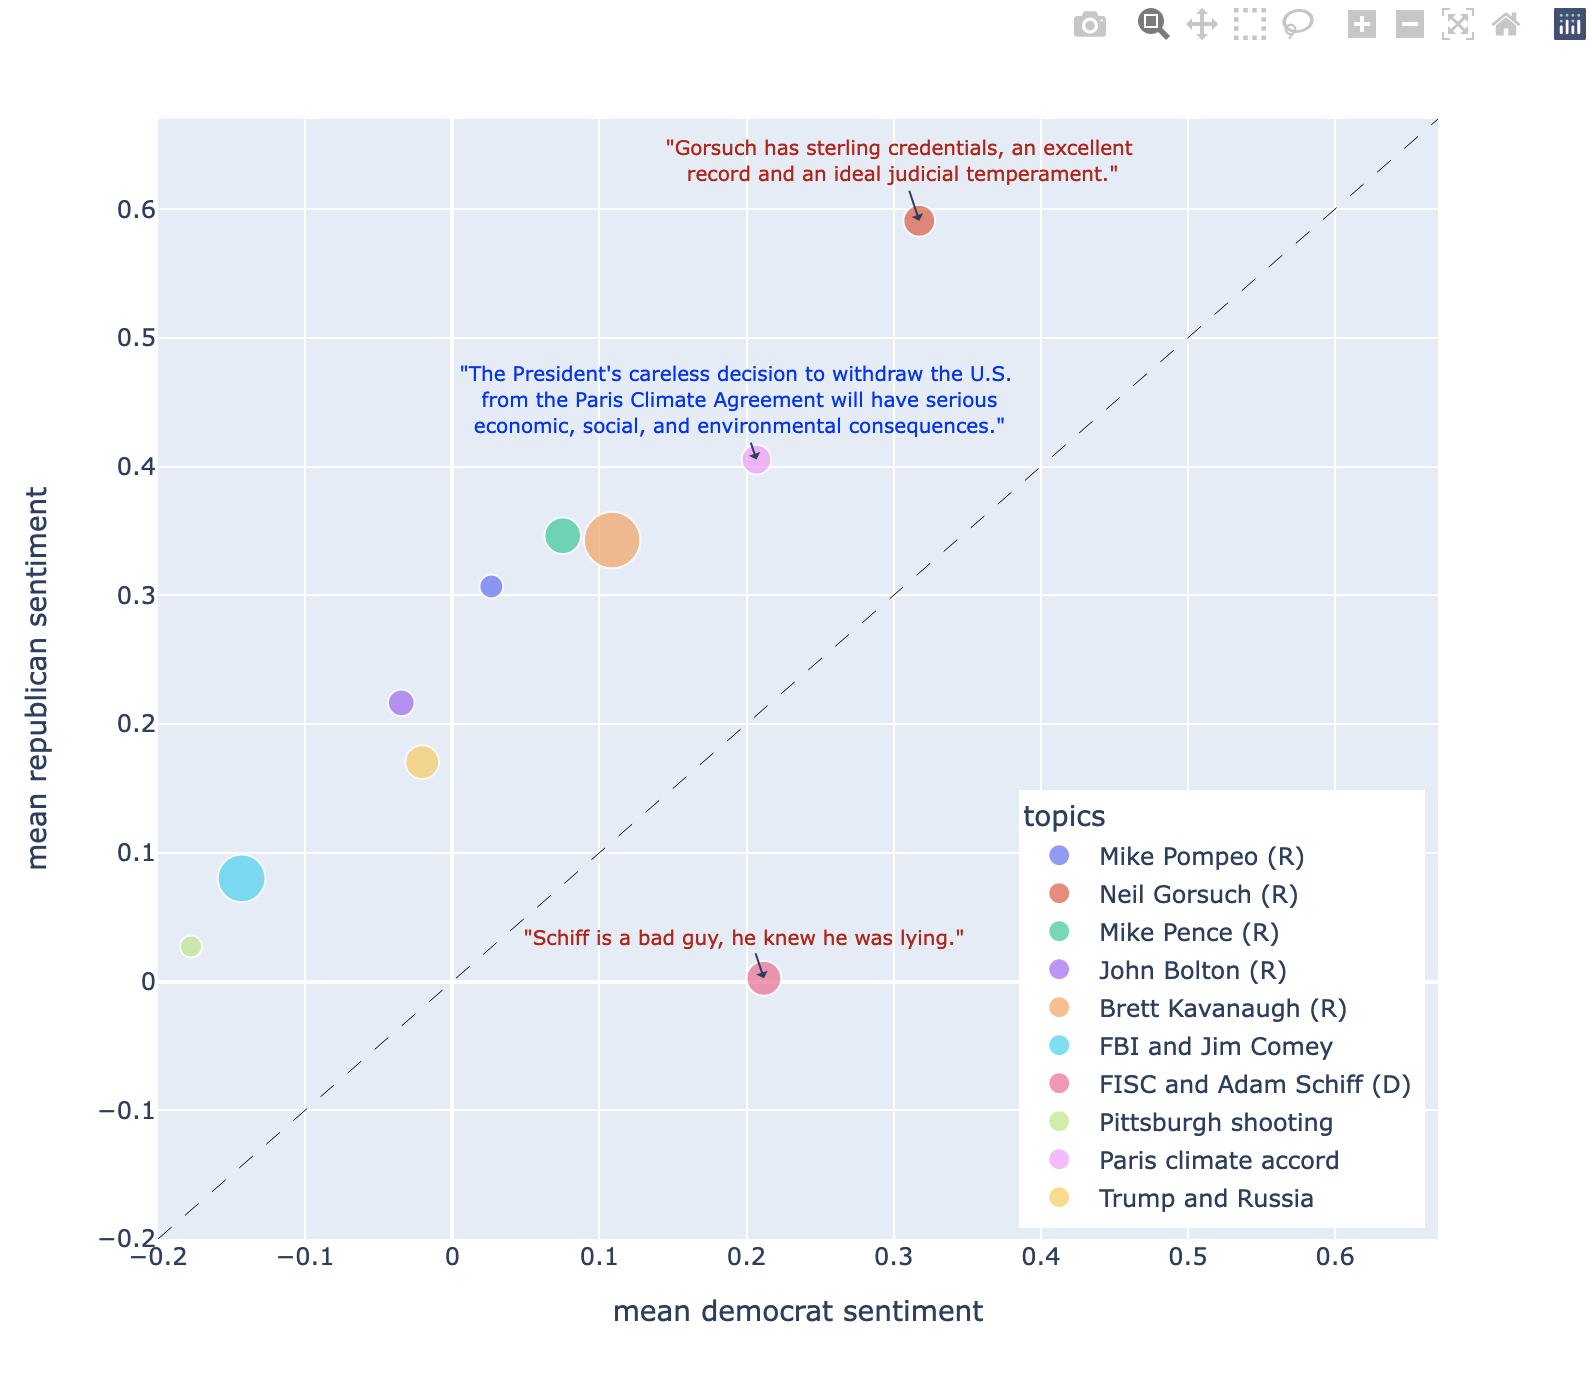

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/Topic_analysis/topic_bubbleplot.png')

### 5.3.5. Sentiment of selected speakers

Finally, we are interested in how specific politicians feel about those topics.

In [ ]:
sorted_selected_topics = np.asarray([int(t) for t in selected_topic_descriptions.keys()]).astype(str)

In [ ]:
# Get a matrix with politicians as rows, topics as columns, and the mean sentiment of a politician on a topic as value
selected_politicians_df = df_politicians[df_politicians.speaker.isin(selected_speakers)]
selected_opinions = opinions_filtered.loc[selected_politicians_df.index, sorted_selected_topics].fillna(0)
selected_opinions = selected_opinions.rename(index=selected_politicians_df.speaker.to_dict(), columns=selected_topic_descriptions)
selected_opinions

,Iran nuclear deal,Tax policy,Gender and race equality,Youth,Police,Mike Pompeo (R),Mike Pence (R),Neil Gorsuch (R),John Bolton (R),Brett Kavanaugh (R),FBI and Jim Comey,FISC and Adam Schiff (D),Paris climate accord,Pittsburgh shooting,Trump and Russia
qids,,,,,,,,,,,,,,,
John McCain,0.030728,0.298795,0.127227,0.032379,0.026278,0.447400,-0.181380,0.280167,0.000000,0.764614,0.181976,-0.199350,0.000000,0.000000,0.000000
Kamala Harris,-0.515212,0.129221,0.090660,0.023545,0.177052,0.000000,0.079814,0.110117,0.636900,0.157981,-0.069700,-0.510600,-0.161367,-0.756875,-0.178548
President Clinton,-0.187519,0.217692,0.179709,0.220955,0.147647,0.000000,0.000000,0.000000,0.000000,0.191900,0.007000,0.335250,0.145100,-0.481600,-0.113333
Nancy Pelosi,-0.105560,0.005596,0.207988,0.086133,-0.257674,-0.146800,-0.209662,-0.262225,0.399487,0.039808,-0.028409,0.372125,0.314900,-0.668650,-0.303033
Ted Cruz,-0.149586,0.043568,0.115737,0.141495,-0.069528,0.718400,0.564519,0.316110,0.355520,0.195520,-0.053057,0.062344,0.137867,0.000000,0.164333
Lindsey Graham,-0.115572,0.177943,-0.060360,0.109706,-0.040721,0.162281,0.366812,0.290359,0.064130,0.042384,0.069163,-0.060102,0.888500,0.000000,0.119508
President Trump,-0.080787,0.056876,0.179852,0.158435,0.066430,0.383928,0.253776,0.538820,0.119208,0.187793,-0.097729,-0.245197,0.391263,-0.084101,0.025160
Mike Pence,-0.022759,0.053196,0.150687,0.193094,0.286074,0.461489,0.189439,0.648222,0.232900,0.431530,0.175308,-0.016667,0.108679,-0.133536,0.137482
Ilhan Omar,-0.390882,0.290137,0.011645,0.163835,-0.056087,-0.434100,-0.812600,0.000000,-0.525600,0.124150,0.000000,0.000000,0.000000,-0.913600,0.000000


In [ ]:
# These two functions will be used give the name of each politician
# the color of their party
def map_party_to_color(party):
  if party=='Republican Party':
    color = RED
  elif party=='Democratic Party':
    color = BLUE
  else:
    color = '#878787'
  return color

def get_html_colored_string(color, text):
    # color: hexadecimal
    s = "<span style='color:" + str(color) + "'>" + str(text) + "</span> "
    return s

In [ ]:
selected_politicians_df['color'] = selected_politicians_df.party.apply(map_party_to_color)
selected_politicians_df = selected_politicians_df.sort_values('party')

In [ ]:
ticktext_x = [get_html_colored_string(c, t) for t, c in selected_politicians_df.set_index('speaker').color.to_dict().items()] # Give politicians the color of their party
ticktext_y = [selected_topic_descriptions[t] for t in divisive_topics.index] + \
             ["<i>"+selected_topic_descriptions[t]+"</i>" for t in list(popular_topic_descriptions.keys())]  # Make most popular topics italic

fig = px.imshow(
                selected_opinions.transpose(),
                x = ticktext_x,
                y = ticktext_y,
                width=760,
                height=600,
                labels=dict(x='Politician', y='Topic', color='Sentiment'),
                color_continuous_scale='Geyser_r'
)

fig.update_xaxes(side="top",
                 
)

fig.add_shape(
              type="line",
              x0=-0.5, 
              y0=9.5, 
              x1=18.5, 
              y1=9.5,
              line=dict(
                        color='black',
                        width=1,
                        )
              )

fig.show()
fig.write_html(os.path.join(image_folder,'heatmap.html'))

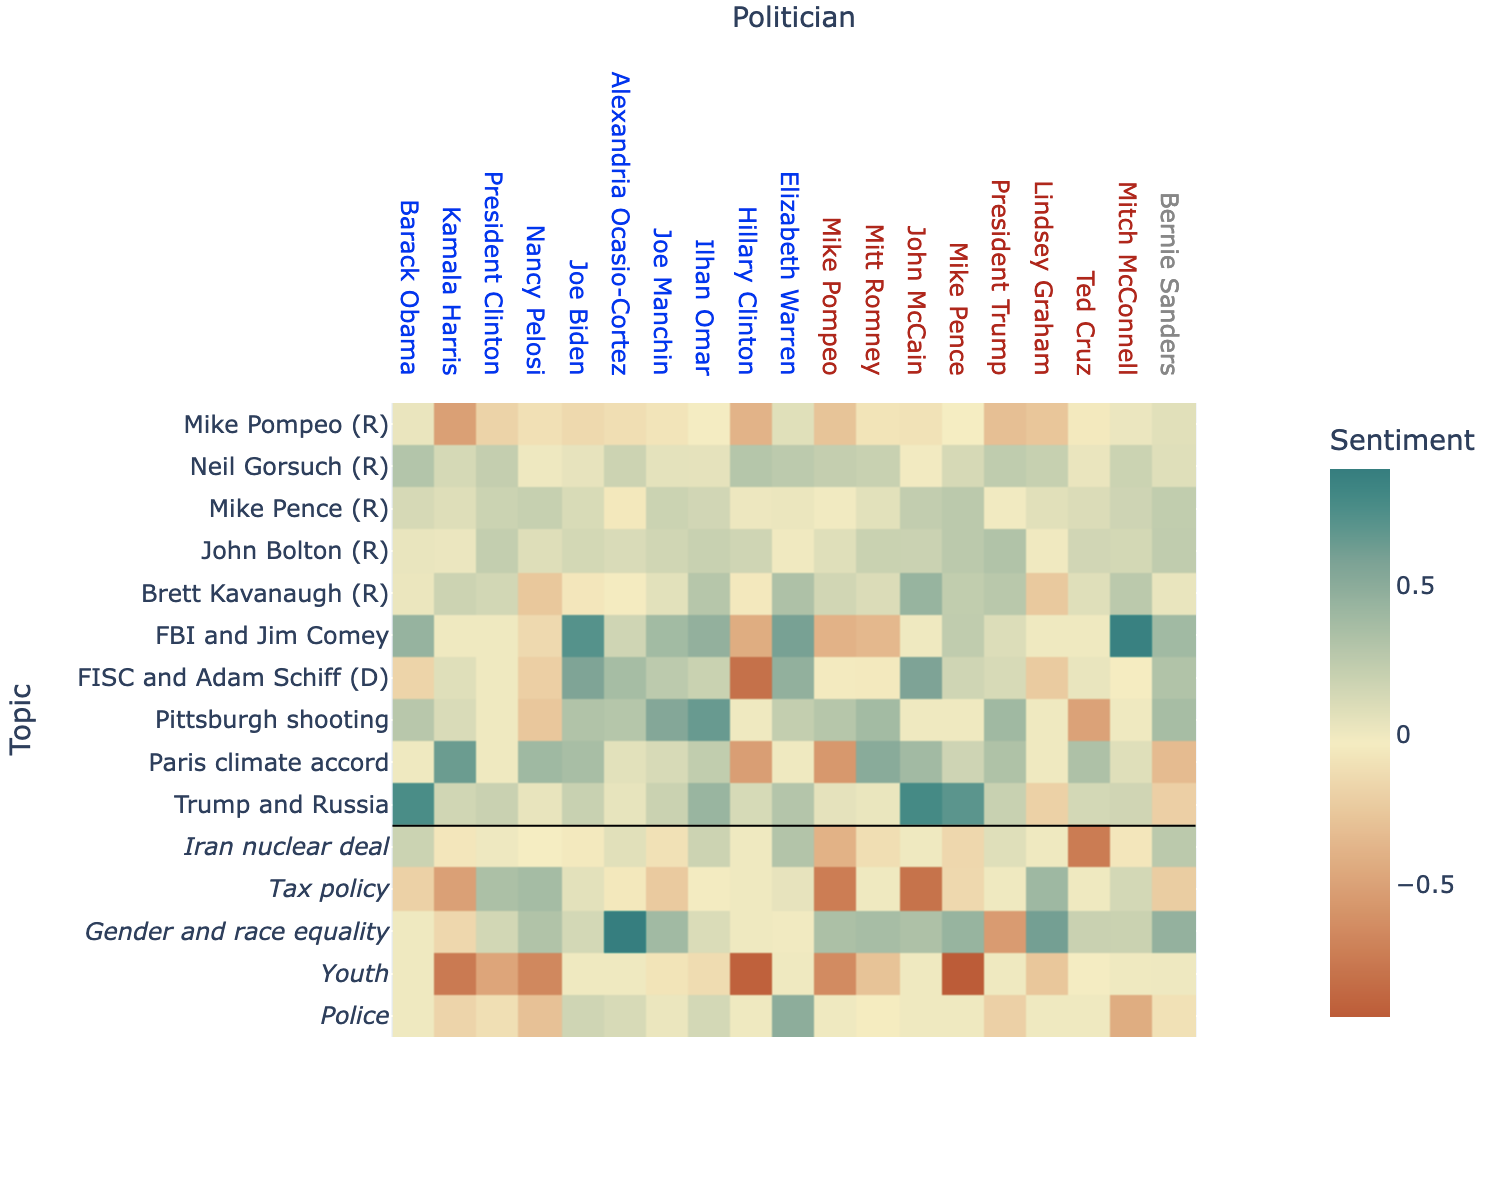

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/Topic_analysis/opinions_heatmap.png')